In [60]:
#!/usr/bin/python

import sys
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.feature_selection import SelectKBest
import numpy
import pandas
import math
#sys.path.append("../tools/")

from feature_format import featureFormat, targetFeatureSplit
from tester import dump_classifier_and_data
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import cross_val_score
from tester import main
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.model_selection import GridSearchCV
from sklearn.cross_validation import StratifiedShuffleSplit

In [5]:
### Task 1: Select what features you'll use.
### features_list is a list of strings, each of which is a feature name.
### The first feature must be "poi".
features_list = ['poi','salary','bonus','total_stock_value','exercised_stock_options','total_payments','long_term_incentive'] # You will need to use more features
financial_features_list = ['poi','salary','bonus','deferral_payments','deferred_income','director_fees','exercised_stock_options','expenses','loan_advances','long_term_incentive','restricted_stock','restricted_stock_deferred','total_payments','total_stock_value']
email_feature_list = ['poi','to_messages', 'from_poi_to_this_person', 'from_messages', 'from_this_person_to_poi', 'shared_receipt_with_poi']
### Load the dictionary containing the dataset
with open("final_project_dataset.pkl", "r") as data_file:
    data_dict = pickle.load(data_file)
print 'number of people in data set = ', len(data_dict)
print 'Number of features for every person in the data set:\n', len(data_dict['LAY KENNETH L'].keys())
# of POIs
count = 0
for p in data_dict:
    for i in data_dict[p]:
        if i == "poi":
            if data_dict[p][i] == 1:
                count +=1
print ("There are %d POIs" % (count))
print ("There are %d non POIs" %(146-count))

number of people in data set =  146
Number of features for every person in the data set:
21
There are 18 POIs
There are 128 non POIs


In [8]:
### Task 2: Remove outliers
''' as seen in the outliers section, we saw that there was a "Total" entry in the data set that was a clear outlier.
thus we are removing it
'''
print "length of data set before removing outlier = ", len(data_dict)
data_dict.pop("TOTAL",0)
print "length of data set after removing outlier = ", len(data_dict)

length of data set before removing outlier =  145
length of data set after removing outlier =  145


In [52]:
### Task 3: Create new feature(s)
# Helper function
def computeFraction( poi_messages, all_messages ):
    """ given a number messages to/from POI (numerator) 
        and number of all messages to/from a person (denominator),
        return the fraction of messages to/from that person
        that are from/to a POI
   """
    fraction = 0.
    poi_messages = float(poi_messages)
    all_messages = float(all_messages)
    
    #print "poi_messages = ", poi_messages
    #print "all_messages = ", all_messages
    #if poi_messages=="NaN" or all_messages =="NaN" or all_messages== 0 :
    #    fraction = 0.0
    if math.isnan(poi_messages) or math.isnan(all_messages):
        fraction = 0.0
    else: 
        fraction = float(poi_messages/all_messages)
        if math.isnan(fraction):
            fraction = 0.0
    return fraction
# Computer fraction from poi and to poi
for name in data_dict:
    data_dict[name]['fraction_from_poi'] = computeFraction( data_dict[name]['from_poi_to_this_person'],\
                                                           data_dict[name]['to_messages'] )
    data_dict[name]['fraction_to_poi'] = computeFraction( data_dict[name]['from_this_person_to_poi'],\
                                                           data_dict[name]['from_messages'] )
    


### Store to my_dataset for easy export below.
my_dataset=data_dict


In [73]:
# Verify new features have been added correctly to the data set
df = pandas.DataFrame.from_records(list(data_dict.values()))
employees = pandas.Series(list(data_dict.keys()))

# set the index of df to be the employees series:
df.set_index(employees, inplace=True)
                          
df.head()

,bonus,deferral_payments,deferred_income,director_fees,email_address,exercised_stock_options,expenses,fraction_from_poi,fraction_to_poi,from_messages,...,long_term_incentive,other,poi,restricted_stock,restricted_stock_deferred,salary,shared_receipt_with_poi,to_messages,total_payments,total_stock_value
METTS MARK,600000,NaN,NaN,NaN,mark.metts@enron.com,NaN,94299,0.047088,0.034483,29,...,NaN,1740,False,585062,NaN,365788,702,807,1061827,585062
BAXTER JOHN C,1200000,1295738,-1386055,NaN,NaN,6680544,11200,0.000000,0.000000,NaN,...,1586055,2660303,False,3942714,NaN,267102,NaN,NaN,5634343,10623258
ELLIOTT STEVEN,350000,NaN,-400729,NaN,steven.elliott@enron.com,4890344,78552,0.000000,0.000000,NaN,...,NaN,12961,False,1788391,NaN,170941,NaN,NaN,211725,6678735
CORDES WILLIAM R,NaN,NaN,NaN,NaN,bill.cordes@enron.com,651850,NaN,0.013089,0.000000,12,...,NaN,NaN,False,386335,NaN,NaN,58,764,NaN,1038185
HANNON KEVIN P,1500000,NaN,-3117011,NaN,kevin.hannon@enron.com,5538001,34039,0.030622,0.656250,32,...,1617011,11350,True,853064,NaN,243293,1035,1045,288682,6391065


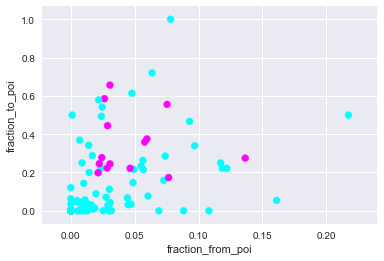

In [91]:
# Visualize new features
x = df['fraction_from_poi'].values
y = df['fraction_to_poi'].values
c = df['poi'].tolist()
plt.scatter(x,y,c=c,cmap='cool')
plt.xlabel("fraction_from_poi")
plt.ylabel("fraction_to_poi")
plt.legend(loc=2)
plt.show()

In the next cell, i am going to extract the features i defined in my list above and select the top 4 features from the financial features and from the email features to help aid my classifier. 

In [10]:
### Extract features and labels from dataset for local testing

# extract the 4 strongest features from the financial data with SelectKBest
financial_data=featureFormat(my_dataset, financial_features_list, sort_keys=True)
financial_labels, financial_features = targetFeatureSplit(financial_data)

# select best features using SelectKBest
test1=SelectKBest(k='all')
fit1=test1.fit(financial_features,financial_labels)

#numpy.set_printoptions(precision=10)
print "printing financial_features k scores: \n", (fit1.scores_)

feature=fit1.transform(financial_features)
# summarize selected features
#print(feature)

#print features
#print labels
#print financial_features[3]

#extract the 4 strongest features from email data with SelectKBest
email_data=featureFormat(my_dataset, email_feature_list, sort_keys = True)
email_labels, email_features=targetFeatureSplit(email_data)

test2=SelectKBest(k='all')
fit2=test2.fit(email_features,email_labels)

print "printing email_features k scores: \n", (fit2.scores_)

printing financial_features k scores: 
[ 18.57570327  21.06000171   0.21705893  11.59554766   2.10765594
  25.09754153   6.23420114   7.2427304   10.07245453   9.34670079
   0.06498431   8.86672154  24.46765405]
printing email_features k scores: 
[ 0.29296869  2.43137891  0.46640016  1.0853069   4.61945732]


After running SelectKBest seperately on the Finanical Data and Email Data. The following features were identified as the top 4 from each group:
* Financial Data:
    - 'exercised_stock_options'	25.09754153
    - 'total_stock_value'	24.46765405
    - 'bonus'	21.06000171
    - 'salary'	18.57570327



* Email Data:
    - 'shared_receipt_with_poi'	4.61945732
    - 'from_poi_to_this_person'	2.43137891
    - 'from_this_person_to_poi'	1.0853069




Now i am going to combine these feature to extract the top overal features from this set

In [11]:
financial_email_features=['poi','exercised_stock_options','total_stock_value','bonus','salary','shared_receipt_with_poi','from_poi_to_this_person','from_this_person_to_poi','from_messages']
financial_email_data=featureFormat(my_dataset, financial_email_features, sort_keys = True)
labels, financial_email_features=targetFeatureSplit(financial_email_data)

# select 4 best features using SelectKBest
test3=SelectKBest(k='all')
fit3=test3.fit(financial_email_features,labels)

#numpy.set_printoptions(precision=10)
print "printing financial_email_features k scores: \n", (fit3.scores_)


printing financial_email_features k scores: 
[ 21.71552656  21.05899501  17.8573624   15.14904119   6.8822438
   4.1460684    1.90840396   0.24111688]


After running SelectKBest on the top 4 features from each group combined, I observed the following K scores:

Feature 	               Score
- 'exercised_stock_options'	21.71552656
- 'total_stock_value'	21.05899501
- 'bonus'	17.8573624
- 'salary'	15.14904119
- 'shared_receipt_with_poi'	6.8822438
- 'from_poi_to_this_person'	4.1460684
- 'from_this_person_to_poi'	1.90840396
- 'from_messages'	0.24111688


 Features from the financial data seem to be the best features to use to input them into our classifier. I'm going to compare this when I run SelectKBest on all features and also to SelectPercentile

In [92]:
full_feature_list=['poi','salary', 'deferral_payments', 'total_payments', 'loan_advances', 'bonus', 'restricted_stock_deferred', 'deferred_income', 'total_stock_value', 'expenses', 'exercised_stock_options', 'other', 'long_term_incentive', 'restricted_stock', 'director_fees','to_messages','from_poi_to_this_person', 'from_messages', 'from_this_person_to_poi', 'shared_receipt_with_poi','fraction_from_poi','fraction_to_poi']
full_data=featureFormat(my_dataset, full_feature_list, sort_keys = True)
labels, full_features=targetFeatureSplit(full_data)

# select best features using SelectKBest
test4=SelectKBest(k='all')
fit4=test4.fit(full_features,labels)

#numpy.set_printoptions(precision=10)
print "printing full_features k scores: \n", (fit4.scores_)

feature=fit4.transform(full_features)

#print full_features

printing full_features k scores: 
[ 18.57570327   0.21705893   8.86672154   7.2427304   21.06000171
   0.06498431  11.59554766  24.46765405   6.23420114  25.09754153
   4.20497086  10.07245453   9.34670079   2.10765594   1.69882435
   5.34494152   0.1641645    2.42650813   8.74648553   3.21076192
  16.64170707]


After running SelectKBest on the entire feature list, excluding email address, I observed the following K scores:

Feature 	Score
- 'exercised_stock_options'	25.09754153
- 'total_stock_value'	24.46765405
- 'bonus'	21.06000171
- 'salary'	18.57570327
- 'deferred_income'	11.59554766
- 'long_term_incentive'	10.07245453
- 'restricted_stock'	9.34670079
- total_payments'	8.86672154
- 'shared_receipt_with_poi'	8.74648553
- 'loan_advances'	7.2427304
- 'expenses'	6.23420114
- 'from_poi_to_this_person'	5.34494152
- 'other'	4.20497086
- 'from_this_person_to_poi'	2.42650813
- 'director_fees'	2.10765594
- 'to_messages'	1.69882435
- 'deferral_payments'	0.21705893
- 'from_messages'	0.1641645
- 'restricted_stock_deferred'	0.06498431


As seen, the top 4 features from this list is the same when I picked out the top 4 features from each group and ran SelectKBest on the combined list. Lets see if this is the same when using Selectpercentile


In [13]:
from sklearn.feature_selection import SelectPercentile, f_classif
test5=SelectPercentile(f_classif, percentile=10)
fit5=test5.fit(full_features,labels)

#numpy.set_printoptions(precision=10)
print "printing full_features k scores: \n", (fit5.scores_)


printing full_features k scores: 
[ 18.57570327   0.21705893   8.86672154   7.2427304   21.06000171
   0.06498431  11.59554766  24.46765405   6.23420114  25.09754153
   4.20497086  10.07245453   9.34670079   2.10765594   1.69882435
   5.34494152   0.1641645    2.42650813   8.74648553]


After running SelectPercentile, I get the same scores as I did with SelectKBest. I think i found the features i want to use with my classifier. 

Now that I identified the features i want to use,  I am going to try a variety of classifiers without any parameter tunes to explore accuracy, recall, precision, and F1 metrics to help me identify which classifiers I should focus on when I go to tune them. 

In [30]:
### Task 4: Try a varity of classifiers
### Please name your classifier clf for easy export below.
### Note that if you want to do PCA or other multi-stage operations,
### you'll need to use Pipelines. For more info:
### http://scikit-learn.org/stable/modules/pipeline.html


# use and extract features identified in previous cell for classifers. 
features_list=['poi','salary',  'bonus', 'total_stock_value', 'exercised_stock_options']
data=featureFormat(my_dataset, features_list, sort_keys=True)
labels, features = targetFeatureSplit(data)

# split data into training/testing data useing cross validation
features_train, features_test, labels_train, labels_test=\
    train_test_split(features, labels, test_size=0.3, random_state=42)
# list of classifiers and lists to track metric scores
clf_list=[GaussianNB(),tree.DecisionTreeClassifier(),RandomForestClassifier(),SVC(),KNeighborsClassifier()]
recall_list=[]
mean_recall_list=[]

# Using Stratisfied ShuffleSplit since there is an imbalance of POIs and non P
cv = StratifiedShuffleSplit(random_state=42)
# loop through each classifier and capture evaluation metrics
for c in clf_list:
    clf = c
    clf.fit(features_train,labels_train)
    pred=clf.predict(features_test)
    #print pred
    print "Accuracy is ",clf.score(features_test, labels_test)
    print "precision = ", precision_score(labels_test,pred)
    print "recall = ", recall_score(labels_test,pred)
    recall_list.append(recall_score(labels_test,pred))
    print "\nRunning Stratisfied Shuffle Split cross validation to compare recall\n"
    print "printing mean of Stratisfied Shuffle Split"
    print "mean = ",cross_val_score(clf,features,labels,cv=cv.split(features,labels),scoring='recall').mean()
    mean_recall_list.append(cross_val_score(clf,features,labels,cv=cv.split(features,labels),scoring='recall').mean())
    print "\n"
    dump_classifier_and_data(clf, my_dataset, features_list)
    main()
print "printing summary of recall score from Classifiers, \n", recall_list
#print "printing summary of accuracy scores from Classifiers, \n", accuracy_list
print "printing summary of mean recall scores from Stratisfied Shuffle Split CV, \n", mean_recall_list

Accuracy is  0.897435897436
precision =  0.0
recall =  0.0

Running Stratisfied Shuffle Split cross validation to compare recall

printing mean of Stratisfied Shuffle Split
mean =  0.25


GaussianNB(priors=None)
	Accuracy: 0.84677	Precision: 0.50312	Recall: 0.32300	F1: 0.39342	F2: 0.34791
	Total predictions: 13000	True positives:  646	False positives:  638	False negatives: 1354	True negatives: 10362

Accuracy is  0.897435897436
precision =  0.5
recall =  0.25

Running Stratisfied Shuffle Split cross validation to compare recall

printing mean of Stratisfied Shuffle Split
mean =  0.2


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
	Accuracy: 0.79015	Precision: 0.32347	Recall: 0.33350	F1: 

Since I didn’t have a particular algorithm to try in mind, I chose to iterate through several classifiers to evaluate different metrics without making any parameter tunes to get a baseline of how each classifier performs. This will help me choose which classifier to focus tuning parameters on. When iterating, I captured the accuracy of a feature train/test split as well as a mean accuracy when running Stratisfied Shuffle split validation test to compare the two scores. I felt it was necessary to perform Stratisfied Shuffle split cross validation because of the imbalance in POIs and non POIs and to ensure all data is included in a test and a training procedure. Additionally, I dumped out the classifier, dataset, and feature list in each iteration so I can call tester.py. I recorded all the scores the tester file provides scores of each classifier. After iterating through each classier, I observed the following metrics:


|Classifier|Accuracy|Precision|Recall|Mean 10 Fold CV Accuracy|F1 Score|
|-------|------|------|-------|------|------|
|Naive Bayes |.847|.503|.323|.855|.393|
|Decision Tree|.790|.327|.337|.793|.332|
|Random Forest|.846|.479|.229|.863|.310|
|SVC|N/A|N/A|N/A|.862|N/A|
|K Nearest Neighbor|.866|.66|.269|.871|.382|

Due to the drawbacks accuracy can have when evaluating a classifier, I am choosing to focus on Precision and Recall. The classifiers that have the highest precision are:
- Naive Bayes
- K Nearest Neighbor

The classifiers that have the highest recall are :
- Decision Tree
- Naive Bayes

Metrics for SVC was not recorded due to errors. I am going to try some feature scaling and parameter tunes to see if that helps the issue now and re-evaluate. 


In [12]:
from sklearn.preprocessing import MinMaxScaler

features_list=['poi','salary',  'bonus', 'total_stock_value', 'exercised_stock_options']
data=featureFormat(my_dataset, features_list, sort_keys=True)
labels, features=targetFeatureSplit(data)
new_finance_features=numpy.array(features) +0.

scaler = MinMaxScaler()
rescaled_features=scaler.fit_transform(new_finance_features)

#print "printing rescaled_features \n", rescaled_features

param_grid1={'C': [1, 10, 100, 1000],},
param_grid2={'C': [1, 10, 100, 1000], 'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1],}
param_grid3={'C': [1, 10, 100],
              'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }

features_train1, features_test1, labels_train1, labels_test1=\
    train_test_split(rescaled_features, labels, test_size=0.3, random_state=42)


clf = GridSearchCV(SVC(kernel='rbf'), param_grid1,scoring='recall')
clf.fit(features_train1, labels_train1)
print("Best estimator found by grid search:")
print(clf.best_estimator_)
print(clf.best_params_)
print(clf.best_index_)
print(clf.best_score_)    
    
    

Best estimator found by grid search:
SVC(C=1000, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
{'C': 1000}
3
0.204395604396


In [13]:
clf=SVC(C=1000, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
clf.fit(features_train1,labels_train1)
pred=clf.predict(features_test1)
#print pred
print "Accuracy is ",clf.score(features_test1, labels_test1)
print "\nRunning 10 fold cross validation to compare accuracy\n"
print "printing mean of 10 fold CV"
print "mean = ",cross_val_score(clf,rescaled_features,labels,cv=10,scoring='accuracy').mean()
print "\n"
print "precision = ", precision_score(labels_test1,pred)
print "recall = ", recall_score(labels_test1,pred)
dump_classifier_and_data(clf, my_dataset, features_list)
main()

    


Accuracy is  0.897435897436

Running 10 fold cross validation to compare accuracy

printing mean of 10 fold CV
mean =  0.870787545788


precision =  0.0
recall =  0.0
Got a divide by zero when trying out: SVC(C=1000, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
Precision or recall may be undefined due to a lack of true positive predicitons.


It doesnt look like feature scaling or parameter tunes helped much in terms of evaulating Precision and Recall. 

Having good recall means that nearly every time a POI shows up in my test set, I am able to identify him or her. Because of this, I am going to try and tune the classifiers that have the highest baseline of recall to see if I can improve the recall score. I feel this is the important metric to focus on because I want to make sure I dont miss a POI when they show up in the test set. When applying this to the enron case, I feel it is more important to be able to identify POIs even if there are some false positives. False postives can be proven innocent through court trials and rulings made on the individuals. However, if a POI is missed, they could walk free and never be brought to justice. 

Since parameter tuning is not needed on Naive Bayes, I am going to do paramater tuning on the alogrithms I initially tried. 


In [32]:
### Task 5: Tune your classifier to achieve better than .3 precision and recall 
### using our testing script. Check the tester.py script in the final project
### folder for details on the evaluation method, especially the test_classifier
### function. Because of the small size of the dataset, the script uses
### stratified shuffle split cross validation. For more info: 
### http://scikit-learn.org/stable/modules/generated/sklearn.cross_validation.StratifiedShuffleSplit.html

# Tuning Decision Tree


param_grid={'criterion':('gini','entropy'),'splitter':('best','random'),'min_samples_split':[2,50,100,1000],
                'max_features':[1,2,3,4],}
cv = cv = StratifiedShuffleSplit(random_state=42)
clf1=tree.DecisionTreeClassifier()
clf=GridSearchCV(clf1, param_grid,scoring='recall',cv=cv)
clf.fit(features_train, labels_train)
print("Best estimator found by grid search:")
print(clf.best_estimator_)
print(clf.best_params_)
print(clf.best_index_)
print(clf.best_score_)

Best estimator found by grid search:
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=3, max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='random')
{'max_features': 3, 'min_samples_split': 2, 'criterion': 'gini', 'splitter': 'random'}
17
0.45


In [34]:
# Tune Decision Tree
clf=tree.DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=3, max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='random')


clf.fit(features_train,labels_train)

pred=clf.predict(features_test)
    #print pred
print "Accuracy is ",clf.score(features_test, labels_test)
print "precision = ", precision_score(labels_test,pred)
print "recall = ", recall_score(labels_test,pred)
print "\nRunning Stratisfied Shuffle split to compare accuracy\n"
print "printing mean of Stratisfied Shuffle Split fold CV"
print "mean = ",cross_val_score(clf,features,labels,cv=cv.split(features,labels),scoring='recall').mean()
print "\n"
dump_classifier_and_data(clf, my_dataset, features_list)
main()

Accuracy is  0.897435897436
precision =  0.5
recall =  0.5

Running Stratisfied Shuffle split to compare accuracy

printing mean of 10 fold CV
mean =  0.25


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=3, max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='random')
	Accuracy: 0.78754	Precision: 0.31505	Recall: 0.32450	F1: 0.31970	F2: 0.32256
	Total predictions: 13000	True positives:  649	False positives: 1411	False negatives: 1351	True negatives: 9589



When doing parameter tuning on Decision Tree using GridsearchCV, i had to set the scorer to recall in order to get the parameters that produced the highest recall. This seemed to help as I now get a recall score of .33. Let see how the other algorithms do. 

In [35]:
# Tune Random Forest
param_grid={'min_samples_split':[2,50,100],
                'n_estimators':[5,10,50,100],}

clf1=RandomForestClassifier()
clf=GridSearchCV(clf1, param_grid,scoring='recall',cv=cv)
clf.fit(features_train, labels_train)
print("Best estimator found by grid search:")
print(clf.best_estimator_)
print(clf.best_params_)
print(clf.best_index_)
print(clf.best_score_)
#print(clf.feature_importances_)

Best estimator found by grid search:
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=5, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
{'min_samples_split': 2, 'n_estimators': 5}
0
0.3


In [38]:
clf=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=5, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)


clf.fit(features_train,labels_train)

pred=clf.predict(features_test)
    #print pred
print "Accuracy is ",clf.score(features_test, labels_test)
print "precision = ", precision_score(labels_test,pred)
print "recall = ", recall_score(labels_test,pred)
print "\nRunning Stratisfied Shuffle split to compare accuracy\n"
print "printing mean of Stratisfied Shuffle Split fold CV"
print "mean = ",cross_val_score(clf,features,labels,cv=cv.split(features,labels),scoring='recall').mean()
print "\n"
dump_classifier_and_data(clf, my_dataset, features_list)
main()

 Accuracy is  0.820512820513
precision =  0.2
recall =  0.25

Running Stratisfied Shuffle split to compare accuracy

printing mean of Stratisfied Shuffle Split fold CV
mean =  0.2


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=5, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
	Accuracy: 0.82954	Precision: 0.41806	Recall: 0.27550	F1: 0.33213	F2: 0.29566
	Total predictions: 13000	True positives:  551	False positives:  767	False negatives: 1449	True negatives: 10233



When doing some parameter tuning on RandomForest, my recall improves a little bit but not enough as it is still below .3. I will try parameter tuning on some other algorithms and see if I can get the recall score above .3

In [39]:
# Tune K Nearest Neighbors
k=numpy.arange(10)+1
param_grid={'n_neighbors':k}

clf1=KNeighborsClassifier()
clf=GridSearchCV(clf1, param_grid,scoring = 'recall',cv=cv)
clf.fit(features_train, labels_train)
print("Best estimator found by grid search:")
print(clf.best_estimator_)
print(clf.best_params_)
print(clf.best_index_)
print(clf.best_score_)



Best estimator found by grid search:
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=1, p=2,
           weights='uniform')
{'n_neighbors': 1}
0
0.35


In [41]:
clf=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=1, p=2,
           weights='uniform')


clf.fit(features_train,labels_train)

pred=clf.predict(features_test)
    #print pred
print "Accuracy is ",clf.score(features_test, labels_test)
print "precision = ", precision_score(labels_test,pred)
print "recall = ", recall_score(labels_test,pred)
print "\nRunning Stratisfied Shuffle split to compare accuracy\n"
print "printing mean of Stratisfied Shuffle Split fold CV"
print "mean = ",cross_val_score(clf,features,labels,cv=cv.split(features,labels),scoring='recall').mean()
print "\n"
dump_classifier_and_data(clf, my_dataset, features_list)
main()

Accuracy is  0.846153846154
precision =  0.333333333333
recall =  0.5

Running Stratisfied Shuffle split to compare accuracy

printing mean of Stratisfied Shuffle Split fold CV
mean =  0.3


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=1, p=2,
           weights='uniform')
	Accuracy: 0.84369	Precision: 0.48973	Recall: 0.38150	F1: 0.42889	F2: 0.39914
	Total predictions: 13000	True positives:  763	False positives:  795	False negatives: 1237	True negatives: 10205



After doing some parameter tunes on my classifier algorithms, I observed the following results:

|Classifier|Accuracy|Precision|Recall|Mean 10 Fold CV Accuracy|F1 Score|True positives|False positives|False negatives|True negatives|
|-------|------|------|-------|------|------|-------|------|------|-----|
|Decision Tree|.796|.33|.311|.823|.319|621|1272|1379|9728|
|Random Forest|.833|.433|.284|.854|.342|567|743|1433|10257|
|K Nearest Neighbor|.844|.49|.382|.87|.492|763|795|1237|10205|


Cleary, the algorithm the benefited the most from parameter tuning was K Nearest Neighbor. It achieved the highest recall from all the classifiers I explored. Now I am going to use K Nearest Neighbor with the optimal value for K and evaluate the precision and recall i get when testing the classifier. 

In [43]:
# Run K Nearest Neighbor with optimal K Value and dump out performance metrics

clf=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=1, p=2,
           weights='uniform')


clf.fit(features_train,labels_train)

pred=clf.predict(features_test)
    #print pred
print "Accuracy is ",clf.score(features_test, labels_test)
print "precision = ", precision_score(labels_test,pred)
print "recall = ", recall_score(labels_test,pred)
print "\nRunning Stratisfied Shuffle split to compare recall\n"
print "printing mean of Stratisfied Shuffle Split fold CV"
print "mean recall = ",cross_val_score(clf,features,labels,cv=cv.split(features,labels),scoring='recall').mean()
print "mean precision = ",cross_val_score(clf,features,labels,cv=cv.split(features,labels),scoring='precision').mean()
print "\n"
dump_classifier_and_data(clf, my_dataset, features_list)
main()


Accuracy is  0.846153846154
precision =  0.333333333333
recall =  0.5

Running Stratisfied Shuffle split to compare recall

printing mean of Stratisfied Shuffle Split fold CV
mean recall =  0.3
mean precision =  0.35


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=1, p=2,
           weights='uniform')
	Accuracy: 0.84369	Precision: 0.48973	Recall: 0.38150	F1: 0.42889	F2: 0.39914
	Total predictions: 13000	True positives:  763	False positives:  795	False negatives: 1237	True negatives: 10205



As seen from above, when running Stratisfied Shuffle Split, I achieve a mean recall of .3 and a mean precision of .35. When the tester.py file is called, I achieve a recall of .382 and a precision of .49

In [ ]:
### Task 6: Dump your classifier, dataset, and features_list so anyone can
### check your results. You do not need to change anything below, but make sure
### that the version of poi_id.py that you submit can be run on its own and
### generates the necessary .pkl files for validating your results.

dump_classifier_and_data(clf, my_dataset, features_list)

In [ ]:
# %load tester.py
#!/usr/bin/pickle

""" a basic script for importing student's POI identifier,
    and checking the results that they get from it 
 
    requires that the algorithm, dataset, and features list
    be written to my_classifier.pkl, my_dataset.pkl, and
    my_feature_list.pkl, respectively

    that process should happen at the end of poi_id.py
"""

import pickle
import sys
from sklearn.cross_validation import StratifiedShuffleSplit
sys.path.append("../tools/")
from feature_format import featureFormat, targetFeatureSplit

PERF_FORMAT_STRING = "\
\tAccuracy: {:>0.{display_precision}f}\tPrecision: {:>0.{display_precision}f}\t\
Recall: {:>0.{display_precision}f}\tF1: {:>0.{display_precision}f}\tF2: {:>0.{display_precision}f}"
RESULTS_FORMAT_STRING = "\tTotal predictions: {:4d}\tTrue positives: {:4d}\tFalse positives: {:4d}\
\tFalse negatives: {:4d}\tTrue negatives: {:4d}"

def test_classifier(clf, dataset, feature_list, folds = 1000):
    data = featureFormat(dataset, feature_list, sort_keys = True)
    labels, features = targetFeatureSplit(data)
    cv = StratifiedShuffleSplit(labels, folds, random_state = 42)
    true_negatives = 0
    false_negatives = 0
    true_positives = 0
    false_positives = 0
    for train_idx, test_idx in cv: 
        features_train = []
        features_test  = []
        labels_train   = []
        labels_test    = []
        for ii in train_idx:
            features_train.append( features[ii] )
            labels_train.append( labels[ii] )
        for jj in test_idx:
            features_test.append( features[jj] )
            labels_test.append( labels[jj] )
        
        ### fit the classifier using training set, and test on test set
        clf.fit(features_train, labels_train)
        predictions = clf.predict(features_test)
        for prediction, truth in zip(predictions, labels_test):
            if prediction == 0 and truth == 0:
                true_negatives += 1
            elif prediction == 0 and truth == 1:
                false_negatives += 1
            elif prediction == 1 and truth == 0:
                false_positives += 1
            elif prediction == 1 and truth == 1:
                true_positives += 1
            else:
                print "Warning: Found a predicted label not == 0 or 1."
                print "All predictions should take value 0 or 1."
                print "Evaluating performance for processed predictions:"
                break
    try:
        total_predictions = true_negatives + false_negatives + false_positives + true_positives
        accuracy = 1.0*(true_positives + true_negatives)/total_predictions
        precision = 1.0*true_positives/(true_positives+false_positives)
        recall = 1.0*true_positives/(true_positives+false_negatives)
        f1 = 2.0 * true_positives/(2*true_positives + false_positives+false_negatives)
        f2 = (1+2.0*2.0) * precision*recall/(4*precision + recall)
        print clf
        print PERF_FORMAT_STRING.format(accuracy, precision, recall, f1, f2, display_precision = 5)
        print RESULTS_FORMAT_STRING.format(total_predictions, true_positives, false_positives, false_negatives, true_negatives)
        print ""
    except:
        print "Got a divide by zero when trying out:", clf
        print "Precision or recall may be undefined due to a lack of true positive predicitons."

CLF_PICKLE_FILENAME = "my_classifier.pkl"
DATASET_PICKLE_FILENAME = "my_dataset.pkl"
FEATURE_LIST_FILENAME = "my_feature_list.pkl"

def dump_classifier_and_data(clf, dataset, feature_list):
    with open(CLF_PICKLE_FILENAME, "w") as clf_outfile:
        pickle.dump(clf, clf_outfile)
    with open(DATASET_PICKLE_FILENAME, "w") as dataset_outfile:
        pickle.dump(dataset, dataset_outfile)
    with open(FEATURE_LIST_FILENAME, "w") as featurelist_outfile:
        pickle.dump(feature_list, featurelist_outfile)

def load_classifier_and_data():
    with open(CLF_PICKLE_FILENAME, "r") as clf_infile:
        clf = pickle.load(clf_infile)
    with open(DATASET_PICKLE_FILENAME, "r") as dataset_infile:
        dataset = pickle.load(dataset_infile)
    with open(FEATURE_LIST_FILENAME, "r") as featurelist_infile:
        feature_list = pickle.load(featurelist_infile)
    return clf, dataset, feature_list

def main():
    ### load up student's classifier, dataset, and feature_list
    clf, dataset, feature_list = load_classifier_and_data()
    ### Run testing script
    test_classifier(clf, dataset, feature_list)

if __name__ == '__main__':
    main()
